<a href="https://colab.research.google.com/github/sharathchandran2001/GeneralUtils/blob/main/1_quantum_chess_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ♟️ Quantum Chess Evaluator – Overview

This notebook demonstrates a **quantum-enhanced neural network** that evaluates chess positions based on recent move sequences. It combines real game data, classical chess logic, and quantum computing concepts into one unified pipeline.

---

## 🧠 Architecture Highlights

| Component | Description |
|----------|-------------|
| **PGN Input** | Sample chess games are embedded directly in PGN format. |
| **Sequence Extraction** | Recent 3-move board sequences are extracted for each game. |
| **FEN Encoding** | Each board state is numerically encoded as a 64-length vector using piece positions. |
| **Labeling via Stockfish** | The Stockfish engine evaluates each final position, labeling it as 'advantageous' (1) or not (0). |
| **Quantum LSTM (QLSTM)** | A hybrid neural network simulates LSTM gates (forget, input, output) using quantum circuits. |
| **Prediction Output** | The model predicts if a given move sequence leads to a better board position. |
| **Visualization** | A chart shows predicted vs. actual outcomes across games. |

---

## 🌀 End-to-End Flow

1. 🧾 Load embedded PGN games  
2. 🔄 Extract 3-position sequences from each game  
3. ♟️ Encode boards numerically using FEN  
4. ♜ Use Stockfish to assign ground-truth evaluation (1 = good, 0 = not good)  
5. ⚛️ Feed data into a QLSTM-based model  
6. 📈 Train and evaluate predictions visually  

---

## 🌍 Real-World Implications

### ✅ 1. **Training Smarter Chess Engines**
This model could be extended to help chess engines *learn* positional strategies rather than relying only on brute-force search.

### ✅ 2. **AI Coaching Assistants**
Use as a backend for chess apps that give *sequence-based advice*, e.g., “your last 3 moves made your position worse.”

### ✅ 3. **Quantum Benchmark for AI**
This serves as a testbed to explore where and how quantum computing can assist in sequential pattern learning (like in games or financial time series).

---

## 💡 Why This Matters

> This experiment shows how **quantum circuits can be integrated into real-world AI workflows**, starting with games like chess that involve long-term strategy and sequence understanding.



In [ ]:
# ✅ Install dependencies (run once)
# !pip install pennylane torch scikit-learn matplotlib --quiet
!pip install pennylane torch chess stockfish --quiet
!apt-get install -y stockfish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 64.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━

Epoch 0: Loss=0.6822 Accuracy=0.69
Epoch 5: Loss=0.6726 Accuracy=0.69
Epoch 10: Loss=0.6639 Accuracy=0.69
Epoch 15: Loss=0.6562 Accuracy=0.69

Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ground Truth: [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


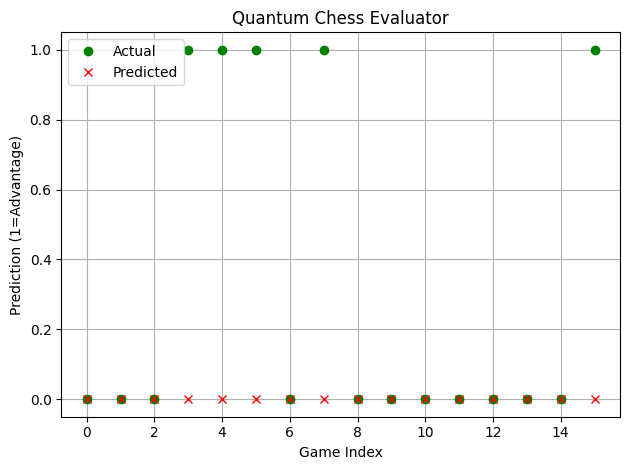

In [ ]:
# ✅ Install dependencies
# !pip install pennylane torch chess stockfish --quiet
# !apt-get install -y stockfish

# ✅ Imports
import chess
import chess.pgn
from stockfish import Stockfish
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import io
from stockfish import Stockfish

# ✅ Embedded PGN games
pgn_string = """
[Event "Sample Game 1"]
[Site "https://lichess.org"]
[Date "2023.05.01"]
[Round "?"]
[White "Player1"]
[Black "Player2"]
[Result "1-0"]

1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-O Be7

[Event "Sample Game 2"]
[Site "https://lichess.org"]
[Date "2023.05.02"]
[Round "?"]
[White "Player3"]
[Black "Player4"]
[Result "0-1"]

1. d4 d5 2. c4 c6 3. Nc3 Nf6 4. Nf3 e6 5. Bg5 dxc4
"""

# ✅ Chess board encoder
piece_map = {
    'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
    'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
    '.': 0
}
def encode_board(fen: str) -> np.ndarray:
    board = chess.Board(fen)
    board_array = np.zeros(64, dtype=np.float32)
    i = 0
    for c in board.board_fen():
        if c.isdigit():
            i += int(c)
        elif c in piece_map:
            board_array[i] = piece_map[c]
            i += 1
    return board_array

# ✅ Extract sequences from PGN string
def extract_board_sequences_from_pgn_text(pgn_text, max_games=5, sequence_length=3):
    sequences = []
    pgn_file = io.StringIO(pgn_text)
    count = 0
    while count < max_games:
        game = chess.pgn.read_game(pgn_file)
        if not game:
            break
        board = game.board()
        move_stack = []
        for move in game.mainline_moves():
            board.push(move)
            move_stack.append(board.fen())
            if len(move_stack) >= sequence_length:
                seq = move_stack[-sequence_length:]
                sequences.append(seq)
        count += 1
    return sequences

# ✅ Use Stockfish to label sequences
# stockfish = Stockfish(path="/usr/games/stockfish")  # For Colab, preinstalled here
stockfish = Stockfish(path="/usr/games/stockfish")  # works after install

def label_sequence_with_stockfish(fen_seq, threshold=0.5):
    stockfish.set_fen_position(fen_seq[-1])
    eval_info = stockfish.get_evaluation()
    if eval_info["type"] == "cp":
        score = eval_info["value"] / 100.0
    elif eval_info["type"] == "mate":
        score = 10 if eval_info["value"] > 0 else -10
    else:
        score = 0
    return 1 if score > threshold else 0

# ✅ Prepare training data
all_sequences = extract_board_sequences_from_pgn_text(pgn_string, max_games=5)
X_data, y_data = [], []
for seq in all_sequences:
    X_data.append(torch.tensor(np.stack([encode_board(fen) for fen in seq])))
    y_data.append(label_sequence_with_stockfish(seq))
X_tensor = torch.stack(X_data)
y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# ✅ Quantum layer
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_lstm_gate(x, weights):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="torch")
def run_quantum_gate(x, weights):
    return quantum_lstm_gate(x, weights)

# ✅ QLSTM model
class QuantumChessEvaluator(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=8, seq_len=3, n_qubits=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.n_qubits = n_qubits
        self.fw = nn.Parameter(torch.randn((3, n_qubits)))
        self.iw = nn.Parameter(torch.randn((3, n_qubits)))
        self.ow = nn.Parameter(torch.randn((3, n_qubits)))
        self.fc = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Sigmoid())

    def forward(self, x):
        B = x.size(0)
        c_t = torch.zeros((B, self.hidden_dim))
        h_t = torch.zeros((B, self.hidden_dim))
        for t in range(self.seq_len):
            x_t = x[:, t, :]
            f_t, i_t, o_t, c̃_t = [], [], [], []
            for i in range(B):
                x_i = x_t[i].reshape(self.n_qubits, -1).mean(dim=1)
                f = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.fw), dtype=torch.float32))
                i_ = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.iw), dtype=torch.float32))
                o = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.ow), dtype=torch.float32))
                c_tilde = torch.tanh(torch.tensor(run_quantum_gate(x_i, self.iw), dtype=torch.float32))
                f_t.append(f)
                i_t.append(i_)
                o_t.append(o)
                c̃_t.append(c_tilde)
            f_t = torch.stack(f_t)
            i_t = torch.stack(i_t)
            o_t = torch.stack(o_t)
            c̃_t = torch.stack(c̃_t)
            c_t = f_t * c_t + i_t * c̃_t
            h_t = o_t * torch.tanh(c_t)
        return self.fc(h_t)

# ✅ Train the model
model = QuantumChessEvaluator()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        acc = ((y_pred > 0.5) == y_tensor).float().mean()
        print(f"Epoch {epoch}: Loss={loss.item():.4f} Accuracy={acc.item():.2f}")

# ✅ Evaluate & visualize
model.eval()
with torch.no_grad():
    preds = (model(X_tensor) > 0.5).int().flatten()
    print("\nPredictions:", preds.tolist())
    print("Ground Truth:", y_tensor.int().flatten().tolist())
    plt.plot(y_tensor.flatten(), 'go', label="Actual")
    plt.plot(preds, 'rx', label="Predicted")
    plt.title("Quantum Chess Evaluator")
    plt.xlabel("Game Index")
    plt.ylabel("Prediction (1=Advantage)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



=====
Demo version
=====


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


--- Starting Model Training ---
Epoch 0: Loss=0.7039 Accuracy=0.31
Epoch 5: Loss=0.6933 Accuracy=0.31
Epoch 10: Loss=0.6834 Accuracy=0.69
Epoch 15: Loss=0.6743 Accuracy=0.69
--- Model Training Finished ---

--- Evaluating on Original Data ---
Predictions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ground Truth: [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


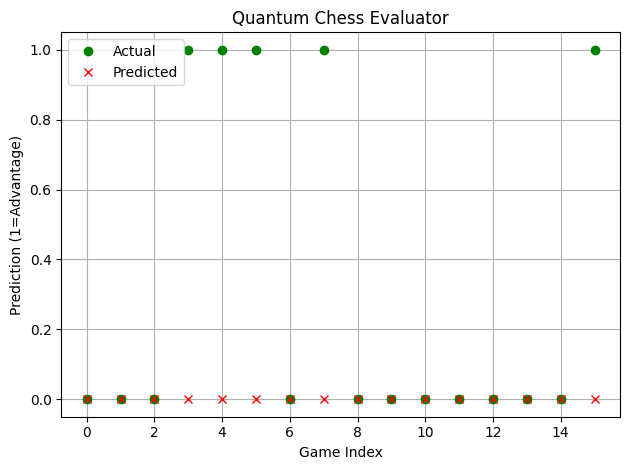


--- Manual Prediction on New Sequences ---
Prediction key: 1 = Advantageous for White, 0 = Not Advantageous

Sequence: ['e4', 'e5', 'Nf3']
Model Prediction: 0
Confidence Score: 0.4613

Sequence: ['d4', 'd5', 'c4']
Model Prediction: 0
Confidence Score: 0.4620

Sequence: ['e4', 'e5', 'Qh5']
Model Prediction: 0
Confidence Score: 0.4634


In [ ]:
# ✅ Install dependencies
!pip install pennylane torch chess stockfish --quiet
!apt-get install -y stockfish

# ✅ Imports
import chess
import chess.pgn
from stockfish import Stockfish
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import io
from stockfish import Stockfish

# ✅ Embedded PGN games
pgn_string = """
[Event "Sample Game 1"]
[Site "https://lichess.org"]
[Date "2023.05.01"]
[Round "?"]
[White "Player1"]
[Black "Player2"]
[Result "1-0"]

1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. O-O Be7

[Event "Sample Game 2"]
[Site "https://lichess.org"]
[Date "2023.05.02"]
[Round "?"]
[White "Player3"]
[Black "Player4"]
[Result "0-1"]

1. d4 d5 2. c4 c6 3. Nc3 Nf6 4. Nf3 e6 5. Bg5 dxc4
"""

# ✅ Chess board encoder
piece_map = {
    'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6,
    'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
    '.': 0
}
def encode_board(fen: str) -> np.ndarray:
    board = chess.Board(fen)
    board_array = np.zeros(64, dtype=np.float32)
    i = 0
    for c in board.board_fen():
        if c.isdigit():
            i += int(c)
        elif c in piece_map:
            board_array[i] = piece_map[c]
            i += 1
    return board_array

# ✅ Extract sequences from PGN string
def extract_board_sequences_from_pgn_text(pgn_text, max_games=5, sequence_length=3):
    sequences = []
    pgn_file = io.StringIO(pgn_text)
    count = 0
    while count < max_games:
        game = chess.pgn.read_game(pgn_file)
        if not game:
            break
        board = game.board()
        move_stack = []
        for move in game.mainline_moves():
            board.push(move)
            move_stack.append(board.fen())
            if len(move_stack) >= sequence_length:
                seq = move_stack[-sequence_length:]
                sequences.append(seq)
        count += 1
    return sequences

# ✅ Use Stockfish to label sequences
try:
    stockfish = Stockfish(path="/usr/games/stockfish")
except FileNotFoundError:
    print("Stockfish not found at /usr/games/stockfish. Please check path or installation.")
    stockfish = None

def label_sequence_with_stockfish(fen_seq, threshold=0.5):
    if not stockfish: return 0 # Return a default value if stockfish is not available
    stockfish.set_fen_position(fen_seq[-1])
    eval_info = stockfish.get_evaluation()
    if eval_info["type"] == "cp":
        score = eval_info["value"] / 100.0
    elif eval_info["type"] == "mate":
        score = 10 if eval_info["value"] > 0 else -10
    else:
        score = 0
    return 1 if score > threshold else 0

# ✅ Prepare training data
all_sequences = extract_board_sequences_from_pgn_text(pgn_string, max_games=5)
X_data, y_data = [], []
for seq in all_sequences:
    X_data.append(torch.tensor(np.stack([encode_board(fen) for fen in seq])))
    y_data.append(label_sequence_with_stockfish(seq))
X_tensor = torch.stack(X_data)
y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# ✅ Quantum layer
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_lstm_gate(x, weights):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

@qml.qnode(dev, interface="torch")
def run_quantum_gate(x, weights):
    return quantum_lstm_gate(x, weights)

# ✅ QLSTM model
class QuantumChessEvaluator(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=8, seq_len=3, n_qubits=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.n_qubits = n_qubits
        self.fw = nn.Parameter(torch.randn((3, n_qubits)))
        self.iw = nn.Parameter(torch.randn((3, n_qubits)))
        self.ow = nn.Parameter(torch.randn((3, n_qubits)))
        self.fc = nn.Sequential(nn.Linear(hidden_dim, 1), nn.Sigmoid())

    def forward(self, x):
        B = x.size(0)
        c_t = torch.zeros((B, self.hidden_dim))
        h_t = torch.zeros((B, self.hidden_dim))
        for t in range(self.seq_len):
            x_t = x[:, t, :]
            f_t, i_t, o_t, c̃_t = [], [], [], []
            for i in range(B):
                x_i = x_t[i].reshape(self.n_qubits, -1).mean(dim=1)
                f = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.fw), dtype=torch.float32))
                i_ = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.iw), dtype=torch.float32))
                o = torch.sigmoid(torch.tensor(run_quantum_gate(x_i, self.ow), dtype=torch.float32))
                c_tilde = torch.tanh(torch.tensor(run_quantum_gate(x_i, self.iw), dtype=torch.float32))
                f_t.append(f)
                i_t.append(i_)
                o_t.append(o)
                c̃_t.append(c_tilde)
            f_t = torch.stack(f_t)
            i_t = torch.stack(i_t)
            o_t = torch.stack(o_t)
            c̃_t = torch.stack(c̃_t)
            c_t = f_t * c_t + i_t * c̃_t
            h_t = o_t * torch.tanh(c_t)
        return self.fc(h_t)

# ✅ Train the model
model = QuantumChessEvaluator()
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("--- Starting Model Training ---")
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        acc = ((y_pred > 0.5) == y_tensor).float().mean()
        print(f"Epoch {epoch}: Loss={loss.item():.4f} Accuracy={acc.item():.2f}")
print("--- Model Training Finished ---\n")

# ✅ Evaluate & visualize
print("--- Evaluating on Original Data ---")
model.eval()
with torch.no_grad():
    preds = (model(X_tensor) > 0.5).int().flatten()
    print("Predictions:", preds.tolist())
    print("Ground Truth:", y_tensor.int().flatten().tolist())
    plt.plot(y_tensor.flatten(), 'go', label="Actual")
    plt.plot(preds, 'rx', label="Predicted")
    plt.title("Quantum Chess Evaluator")
    plt.xlabel("Game Index")
    plt.ylabel("Prediction (1=Advantage)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# NEW SECTION: Manual Prediction
# ----------------------------------------------------------------------

# ✅ Function to predict on a custom move sequence
def predict_on_move_sequence(move_list, trained_model):
    """
    Takes a list of 3 chess moves, processes them, and returns a prediction
    from the trained QLSTM model.

    Args:
        move_list (list): A list of 3 moves in Standard Algebraic Notation (e.g., ['e4', 'e5', 'Nf3']).
        trained_model (nn.Module): The trained QuantumChessEvaluator model.

    Returns:
        tuple: A tuple containing the prediction (0 or 1) and the confidence score (a float between 0 and 1).
    """
    if len(move_list) != 3:
        raise ValueError(f"Expected a list of 3 moves, but got {len(move_list)}.")

    # 1. Generate the sequence of board states (FENs) from the moves
    board = chess.Board()
    fen_sequence = []
    for move_san in move_list:
        try:
            board.push_san(move_san)
            fen_sequence.append(board.fen())
        except ValueError:
            raise ValueError(f"The move '{move_san}' is not a valid move in the current position.")

    # 2. Encode the FEN sequence into a numerical tensor
    encoded_boards = [encode_board(fen) for fen in fen_sequence]
    input_tensor = torch.tensor(np.stack(encoded_boards), dtype=torch.float32).unsqueeze(0) # Add batch dimension

    # 3. Get prediction from the model
    trained_model.eval()
    with torch.no_grad():
        prediction_prob = trained_model(input_tensor).item()

    prediction_label = 1 if prediction_prob > 0.5 else 0

    return prediction_label, prediction_prob

# ✅ Manual Prediction on New Sequences
print("\n--- Manual Prediction on New Sequences ---")
print("Prediction key: 1 = Advantageous for White, 0 = Not Advantageous")

# Example 1: A standard opening (Ruy Lopez)
try:
    ruy_lopez_opening = ['e4', 'e5', 'Nf3']
    prediction, confidence = predict_on_move_sequence(ruy_lopez_opening, model)
    print(f"\nSequence: {ruy_lopez_opening}")
    print(f"Model Prediction: {prediction}")
    print(f"Confidence Score: {confidence:.4f}")
except ValueError as e:
    print(f"Error evaluating sequence: {e}")

# Example 2: Queen's Gambit opening
try:
    queens_gambit_opening = ['d4', 'd5', 'c4']
    prediction, confidence = predict_on_move_sequence(queens_gambit_opening, model)
    print(f"\nSequence: {queens_gambit_opening}")
    print(f"Model Prediction: {prediction}")
    print(f"Confidence Score: {confidence:.4f}")
except ValueError as e:
    print(f"Error evaluating sequence: {e}")

# Example 3: A sequence that should favor Black (Scholar's Mate attempt)
try:
    scholars_mate_attempt = ['e4', 'e5', 'Qh5']
    prediction, confidence = predict_on_move_sequence(scholars_mate_attempt, model)
    print(f"\nSequence: {scholars_mate_attempt}")
    print(f"Model Prediction: {prediction}")
    print(f"Confidence Score: {confidence:.4f}")
except ValueError as e:
    print(f"Error evaluating sequence: {e}")